In [147]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from collections import defaultdict

In [148]:
batches = 8
instances_per_batch = 32

# Define headers in the CSV files
headers = ['Time','Time of Day (min)','Weather ID (#)','Model','Label','Confidence (%)','Size (px^2)','AEB (bool)','DTC (m)','Throttle (%)','Steering (%)','Brake (%)','Handbrake (%)','PosX (m)','PosY (m)','PosZ (m)','RotX (rad)','RotY (rad)','RotZ (rad)','Collisions (#)']

# Load test configuration data
with open("data/config.json", 'r') as file:
    config_data = json.load(file)

# Read and validate the CSV files from all batches, and separate them based on the model
model_to_logs = defaultdict(list)

for batch_id in range(1, batches + 1): 
    for instance_id_batch in range(1, instances_per_batch + 1): 
        df = pd.read_csv(f"data/batch_{batch_id}/aeb_metrics_sim_inst_{instance_id_batch}.csv", skiprows=1, names=headers)
        
        # compute overall instance ID
        instance_id = (batch_id - 1) * instances_per_batch + instance_id_batch - 1
        
        # validate instance metadata
        model = config_data["simulation_instances"][instance_id]["model"]
        model_check = (df['Model'] == model).all()
        tod_check = (df['Time of Day (min)'] == config_data["simulation_instances"][instance_id]["time_of_day"]).all()
        weather_id_check = (df['Weather ID (#)'] == config_data["simulation_instances"][instance_id]["weather_id"]).all()
        if not tod_check or not weather_id_check or not model_check:
            print(f"instance {instance_id} NOT VALID")
            exit()
        
        model_to_logs[model].append(df)
print("All CSV data files have been loaded and validated. ")


All CSV data files have been loaded and validated. 


In [149]:
# Preprocess the data 

max_collision_count = 1
for logs in model_to_logs.values():
    for log in logs: 
         # Ensure the 'Time' column is in datetime format
        log['Time'] = pd.to_datetime(log['Time'], format='%Y-%m-%d %H:%M:%S')

        # Convert timestamps to seconds from the first sample
        time_differences = log['Time'] - log['Time'].iloc[0]
        log['Time'] = time_differences.dt.total_seconds()
        max_collision_count = max(max_collision_count, log['Collisions (#)'].max())

# View the first 5 entries in the first dataframe for yolov2
model_to_logs['yolov2'][0].head()

,Time,Time of Day (min),Weather ID (#),Model,Label,Confidence (%),Size (px^2),AEB (bool),DTC (m),Throttle (%),Steering (%),Brake (%),Handbrake (%),PosX (m),PosY (m),PosZ (m),RotX (rad),RotY (rad),RotZ (rad),Collisions (#)
0,0.000000,300,1,yolov2,NaN,0.0,NaN,0,148.03,0.0,0.0,0.0,0.0,-208.240,-263.091,342.014,0.001,0.004,1.802,0
1,0.473610,300,1,yolov2,NaN,0.0,NaN,0,148.03,0.2,0.0,0.0,0.0,-208.240,-263.091,342.014,0.002,0.004,1.802,0
2,0.826115,300,1,yolov2,NaN,0.0,NaN,0,148.02,0.2,0.0,0.0,0.0,-208.241,-263.083,342.014,0.001,0.004,1.802,0
3,1.217780,300,1,yolov2,NaN,0.0,NaN,0,148.00,0.2,0.0,0.0,0.0,-208.246,-263.065,342.014,0.001,0.004,1.802,0
4,1.630410,300,1,yolov2,NaN,0.0,NaN,0,147.97,0.2,0.0,0.0,0.0,-208.252,-263.037,342.013,0.001,0.004,1.802,0


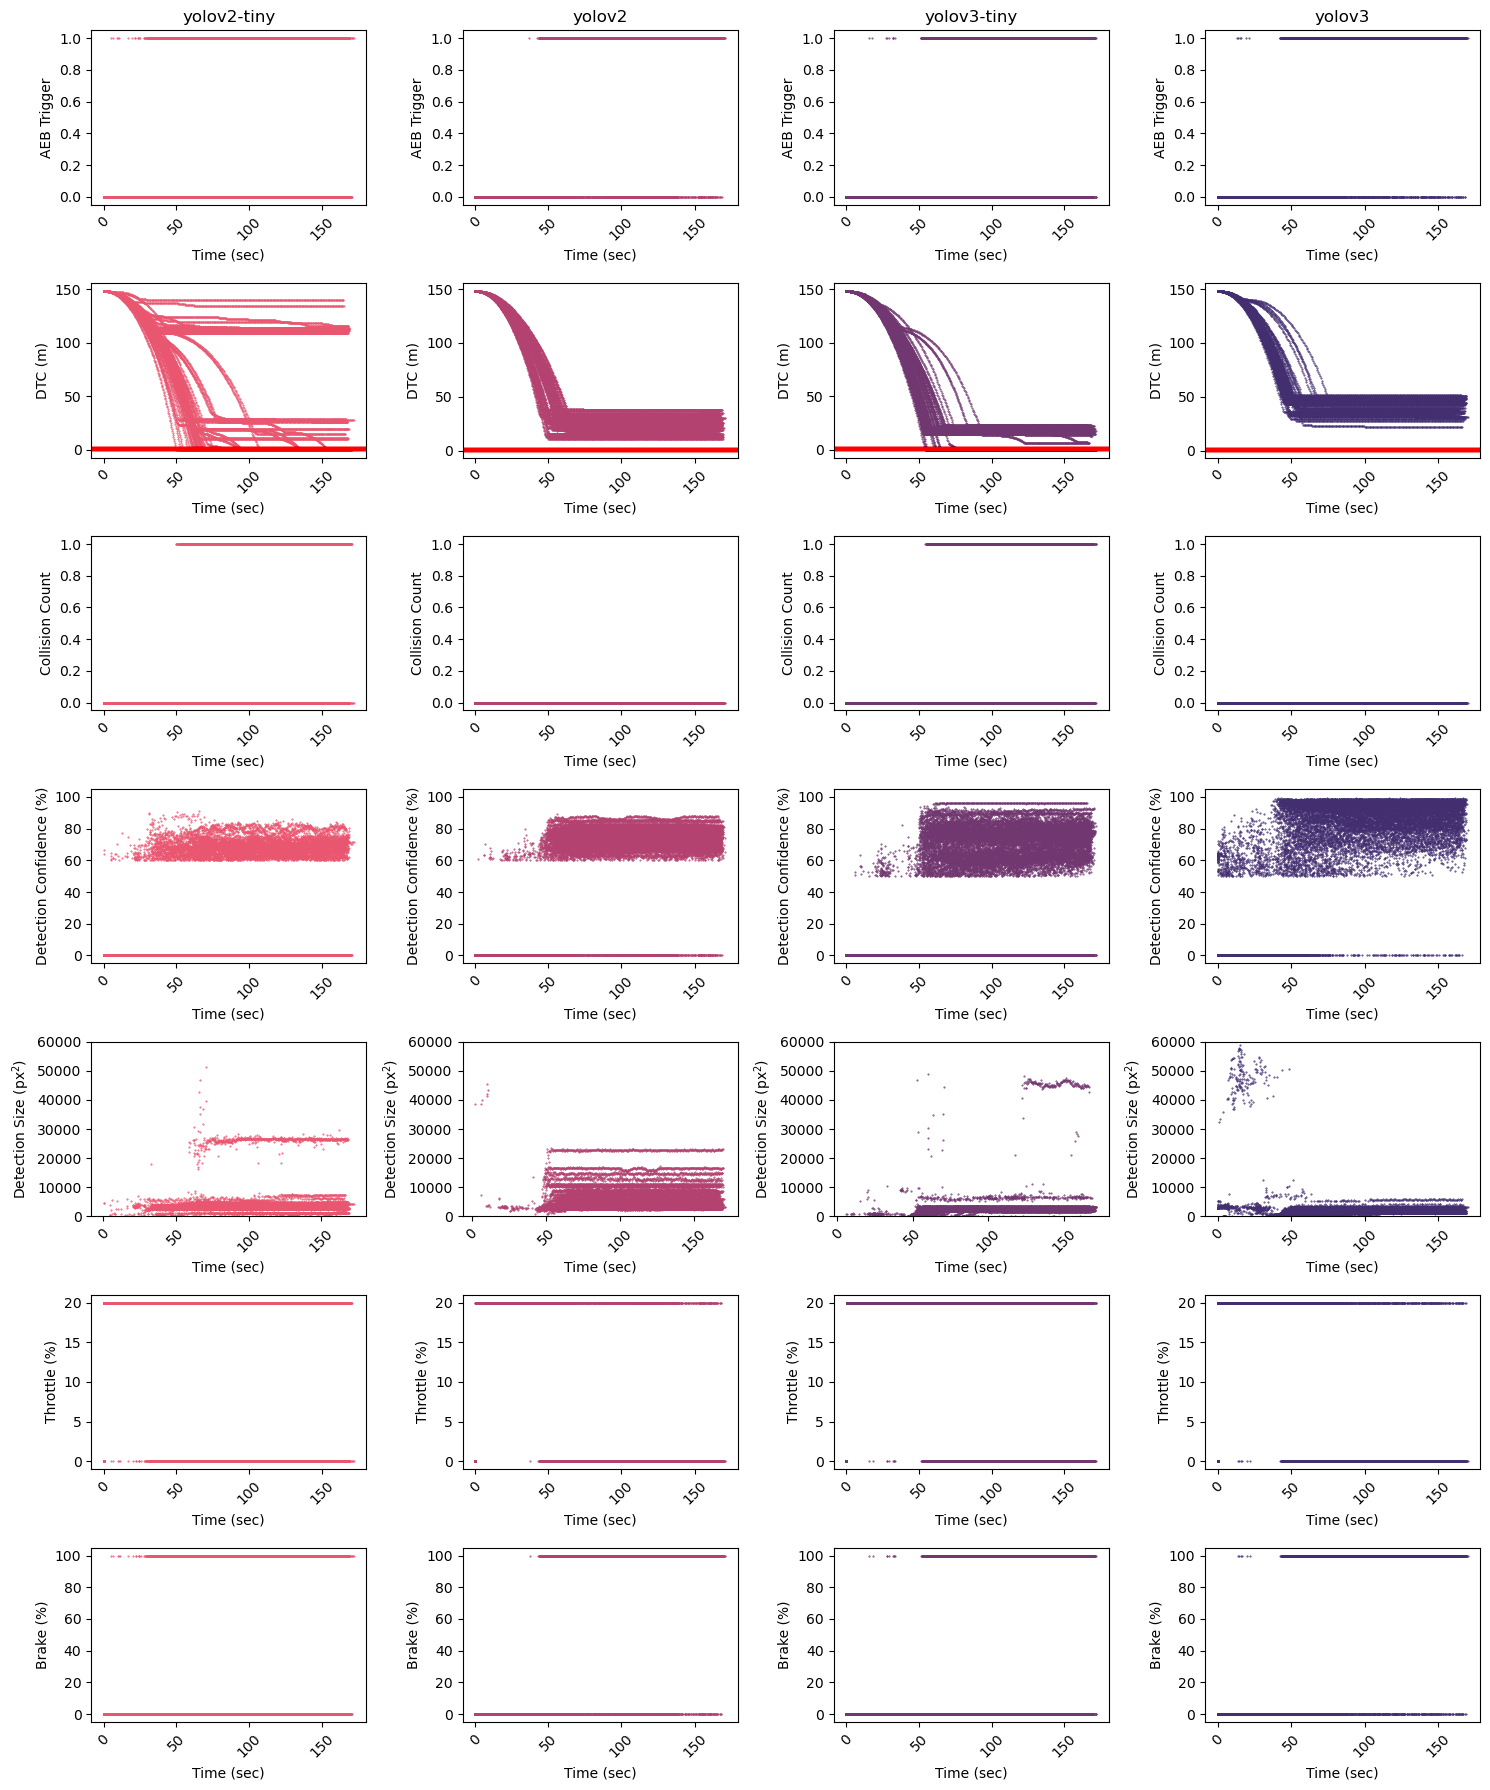

In [89]:
# Visualize the data 

fig = plt.figure(figsize=(15, 18))
G = gridspec.GridSpec(7, 4)

models = ['yolov2-tiny', 'yolov2', 'yolov3-tiny', 'yolov3']
model_to_color = {'yolov2-tiny': '#E95670', 'yolov2': '#B34270', 'yolov3-tiny': '#713770', 'yolov3': '#432F70'}

for i in range(len(models)):
    for j in range(len(model_to_logs[models[i]])):
        log = model_to_logs[models[i]][j]
        
        # Plot AEB Trigger vs. Time
        axes_1 = plt.subplot(G[0, i])
        axes_1.scatter(log['Time'], log['AEB (bool)'], s=0.2, marker='o', color=model_to_color[models[i]])
        axes_1.tick_params(axis='x', labelrotation=45)
        axes_1.set_xlabel(r"Time (sec)")
        axes_1.set_ylabel(r"AEB Trigger")
        axes_1.set_title(models[i])
        
        # Plot DTC vs. Time
        axes_2 = plt.subplot(G[1, i])
        axes_2.scatter(log['Time'], log['DTC (m)'], s=0.2, marker='o', color=model_to_color[models[i]])
        axes_2.axhline(y=1.0, color='r', linestyle='-', linewidth=3.0, alpha=0.1)
        axes_2.tick_params(axis='x', labelrotation=45)
        axes_2.set_xlabel(r"Time (sec)")
        axes_2.set_ylabel(r"DTC (m)")
        
        # Plot Collision Count vs. Time
        axes_3 = plt.subplot(G[2, i])
        axes_3.scatter(log['Time'], (log['Collisions (#)']), s=0.2, marker='o', color=model_to_color[models[i]])
        axes_3.tick_params(axis='x', labelrotation=45)
        axes_3.set_xlabel(r"Time (sec)")
        axes_3.set_ylabel(r"Collision Count")
        axes_3.set_ylim(-0.05, 1.05 * max_collision_count) 
        
        # Plot Detection Confidence vs. Time
        axes_4 = plt.subplot(G[3, i])
        axes_4.scatter(log['Time'], (log['Confidence (%)']), s=0.2, marker='o', color=model_to_color[models[i]])
        axes_4.tick_params(axis='x', labelrotation=45)
        axes_4.set_xlabel(r"Time (sec)")
        axes_4.set_ylabel(r"Detection Confidence (%)")
        axes_4.set_ylim(-5, 105) 

        # Plot Detection Size vs. Time
        axes_5 = plt.subplot(G[4, i])
        axes_5.scatter(log['Time'], (log['Size (px^2)']), s=0.2, marker='o', color=model_to_color[models[i]])
        axes_5.tick_params(axis='x', labelrotation=45)
        axes_5.set_xlabel(r"Time (sec)")
        axes_5.set_ylabel(r"Detection Size (px$^2$)")
        axes_5.set_ylim(0, 60000) 
        
        # Plot Throttle vs. Time
        axes_6 = plt.subplot(G[5, i])
        axes_6.scatter(log['Time'], 100*(log['Throttle (%)']), s=0.2, marker='o', color=model_to_color[models[i]])
        axes_6.tick_params(axis='x', labelrotation=45)
        axes_6.set_xlabel(r"Time (sec)")
        axes_6.set_ylabel(r"Throttle (%)")

        # Plot Brake vs. Time
        axes_7 = plt.subplot(G[6, i])
        axes_7.scatter(log['Time'], 100*(log['Brake (%)']), s=0.2, marker='o', color=model_to_color[models[i]])
        axes_7.tick_params(axis='x', labelrotation=45)
        axes_7.set_xlabel(r"Time (sec)")
        axes_7.set_ylabel(r"Brake (%)")

# Show the plot
plt.tight_layout()
plt.show()

In [146]:
total_cases, passed_cases = 0, 0

max_model_length = max(len(model) for model in models)
for i in range(len(models)):
    model_passed_cases = 0
    model_total_cases = len(model_to_logs[models[i]])
    for j in range(model_total_cases):
        log = model_to_logs[models[i]][j]
        if log['Collisions (#)'].max() == 0: 
            model_passed_cases += 1
    print('Model {:{}}: {}/{} Passed'.format(models[i], max_model_length, model_passed_cases, model_total_cases))
    total_cases += model_total_cases
    passed_cases += model_passed_cases
    
print()
print('Total {:{}}: {}/{} Passed'.format('', max_model_length, passed_cases, total_cases))

Model yolov2-tiny: 27/64 Passed
Model yolov2     : 64/64 Passed
Model yolov3-tiny: 55/64 Passed
Model yolov3     : 64/64 Passed

Total            : 210/256 Passed
